In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class StyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(StyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),1))
        
    def forward(self,x):
        x = self.mlp(x)
        #x = torch.mean(x, dim=1)
        x = torch.sigmoid(x)
        return x.view(x.shape[1])

In [4]:
class AdvStyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AdvStyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),1))
        
    def forward(self,x):
        x = self.mlp(x)
        x = torch.sigmoid(x)
        return x.view(x.shape[1])

In [5]:
class ContentClassifier(nn.Module):
    def __init__(self, input_dim, sequence_length):
        super(ContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                nn.Linear(int(input_dim*0.5),sequence_length))
        
    def forward(self,x):
        x = self.mlp(x)
        #x = torch.mean(x, dim=2)
        x = F.softmax(x,dim=1)
        return x.squeeze(0)

In [6]:
class AdvContentClassifier(nn.Module):
    def __init__(self, input_dim, sequence_length):
        super(AdvContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.mlp = nn.Sequential(nn.Linear(input_dim,input_dim*2),
                                  nn.ReLU(),
                                nn.Linear(input_dim*2,sequence_length))
        
    def forward(self,x):
        x = self.mlp(x)
        #x = torch.mean(x, dim=1)
        x = F.softmax(x,dim=1)
        return x.squeeze(0)

In [7]:
class GRUEncoder(nn.Module):
    def __init__(self, embedding_matrix, embedd_dim, hidden_dim, latent_dim, num_layers):
        super(GRUEncoder, self).__init__()
        self.embedd_dim = embedd_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.style_dim = int(latent_dim/17)
        self.content_dim = latent_dim - int(self.style_dim)

        self.embedder = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(embedd_dim)
        self.gru = nn.GRU(embedd_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fcmu_style = nn.Linear(hidden_dim, 8)
        self.fcvar_style = nn.Linear(hidden_dim, 8)
        self.fcmu_content = nn.Linear(hidden_dim, 128)
        self.fcvar_content = nn.Linear(hidden_dim, 128)

    def forward(self, x):
        embedded_input = self.embedder(x)
        x = self.layer_norm(embedded_input)
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim*2).to(x.device)
        _, h_n = self.gru(x)
    
        #out = torch.norm(out,dim=2) # se vuoi usare questo MODIFICA I LINEAR LAYERS!!!!!!!!!!!!!!!!! PIUTTOSTO FAI IL NORM FUORI DALL'ENCODER E AGGIUNGI EMBEDDER A DECODER!!!!!!!!!!!!!!!!!!
        #out = torch.mean(out,dim=1)
        mu_s = self.fcmu_style(h_n)
        log_var_s = self.fcvar_style(h_n)
        mu_c = self.fcmu_content(h_n)
        log_var_c = self.fcvar_content(h_n)

        z_s = self.reparametrization(mu_s, log_var_s)
        z_c = self.reparametrization(mu_c, log_var_c)
        
        return z_s, z_c, mu_s , log_var_s, mu_c, log_var_c
    
    def reparametrization(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    


class GRUDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers):
        super(GRUDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers


        self.layer_norm = nn.LayerNorm(latent_dim)
        self.gru = nn.GRU(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #h0 = torch.zeros(self.num_layers, x.size(0), int(self.output_dim/2)).to(x.device)
        #out = self.embedder(x)
        #out = self.layer_norm(out)
        #out = self.layer_norm(x)
        out, _ = self.gru(x)
        
        out = self.fc(out)
        out = torch.sigmoid(out)
        #out = out.mean(dim=2)
        #out = out.max(dim=2)
        
        return out

# Train function

In [8]:
def vae_loss(recon_x, x, mu_s, log_var_s, mu_c, log_var_c, l_s = 0.03, l_c = 0.03, loss_fn = nn.MSELoss(), cos_loss = nn.CosineSimilarity(dim=2), wrong = nn.BCELoss()):
    BCE = loss_fn(recon_x, x)
    #BCE = 1 - cos_loss(recon_x,x).mean()
    #BCE = wrong(recon_x,x)
    KLD_s = -0.5 * torch.sum(1 + log_var_s - mu_s.pow(2) - log_var_s.exp())
    KLD_c = -0.5 * torch.sum(1 + log_var_c - mu_c.pow(2) - log_var_c.exp())
    return BCE + l_s*KLD_s + l_c*KLD_c

In [9]:
def mul_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_mul_s = loss_fn(y_s, labels)

    return L_mul_s

In [10]:
def mul_c_loss(y_c, bow, loss_fn=nn.MSELoss()):
    L_mul_c = loss_fn(y_c, bow)

    return L_mul_c

In [11]:
def dis_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_dis_s = loss_fn(y_s, labels)

    return L_dis_s

In [12]:
def dis_c_loss(y_c, bow, loss_fn=nn.MSELoss()):
    L_dis_c = loss_fn(y_c, bow)

    return L_dis_c

In [13]:
def adv_s_loss(y_s, loss_fn=nn.BCELoss()):
    L_adv_s = loss_fn(y_s, y_s)

    return L_adv_s

In [14]:
def adv_c_loss(y_c, loss_fn = nn.BCELoss()):
    L_adv_c = loss_fn(y_c,y_c)

    return L_adv_c

In [15]:
def total_loss(recon_x, x, mu_s, log_var_s, mu_c, log_var_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow, l_muls=10, l_mulc=3, l_advs=1, l_advc=0.03):
    L_VAE = vae_loss(recon_x, x, mu_s, log_var_s, mu_c, log_var_c)
    L_muls = mul_s_loss(y_s, labels)
    L_mulc = mul_c_loss(y_c, bow)
    L_advs = adv_s_loss(y_s_given_c)
    L_advc = adv_c_loss(y_c_given_s)

    return L_VAE + l_muls*L_muls + l_mulc*L_mulc - l_advs*L_advs - l_advc*L_advc

In [16]:
def train_VAE(encoder, decoder,style_classif, adv_style_classif, content_classif, adv_content_classif, train_loader, val_loader, num_epochs, vocab_size, lr = 4e-4):
    params_tot = list(encoder.parameters()) + list(decoder.parameters()) + list(style_classif.parameters()) + list(content_classif.parameters())
    params_dis_s = list(adv_style_classif.parameters())
    params_dis_c = list(adv_content_classif.parameters())

    optimizer_tot = torch.optim.Adam(params_tot, lr = lr)
    optimizer_dis_s = torch.optim.Adam(params_dis_s, lr = lr)
    optimizer_dis_c = torch.optim.Adam(params_dis_c, lr = lr)

    average_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0
        
        #model.train()
        for  i, (data, bow, labels) in enumerate(train_loader):
            data = data.to(device)
            input_data = data/vocab_size
            labels = labels.type(torch.FloatTensor)
            #data = torch.LongTensor(data)

            optimizer_tot.zero_grad()
            optimizer_dis_s.zero_grad()
            optimizer_dis_c.zero_grad()

            z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = encoder(data)

        
            predicted_adv_style = adv_style_classif(z_c)
            predicted_adv_style = predicted_adv_style.type(torch.FloatTensor)
            #print('predicted adv_style shape: ', predicted_adv_style.shape)
            #print('z content shape: ', z_content.shape)
            
            #return mu_style, out1, out
            L_dis_s = dis_s_loss(predicted_adv_style, labels)

            L_dis_s.backward()
            optimizer_dis_s.step()

            z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = encoder(data)


            predicted_adv_content = adv_content_classif(z_s)
            #print('predicted adv_content shape: ', predicted_adv_content.shape)
            #print('z style shape: ', z_style.shape)
            #print('predicted adv_content shape: ', predicted_adv_content.shape)

            L_dis_c = dis_c_loss(predicted_adv_content, bow)

            L_dis_c.backward()
            optimizer_dis_c.step()


            z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = encoder(data)

            z = torch.cat((z_s,z_c),dim = 2)

            
            #mu_style = torch.norm(mu_style,dim=2)
            #log_var_style = torch.norm(log_var_style,dim=2)
            #mu_content = torch.norm(mu_content,dim=2)
            #log_var_content = torch.norm(log_var_content,dim=2)
            #print('z shape: ', z.shape)
            
            #z = torch.norm(z,dim=2)
            #z = z.type(torch.LongTensor)
            #print('new z shape: ', z.shape)
            
            #z_style = torch.norm(z_style,dim=2)
            #z_content = torch.norm(z_content,dim=2)

            recon_data = decoder(z)

            #mu = torch.cat((mu_style,mu_content),dim=1)
            #var = torch.cat((log_var_style.exp(),log_var_content.exp()),dim=1)
            #log_var = torch.log(var)
            #recon_data = torch.norm(recon_data,dim=2)
            #recon_data = torch.mean(recon_data,dim=2) #IS THIS RIGHT?!?!?!?!?!?
            #recon_data = recon_data[:,:,-1]
            #print('z_style shape: ', z_style.shape)
            #print('z content shape: ', z_content.shape)
            #print('x reconstructed shape: ', recon_data.shape)
            y_s = style_classif(z_s)
            y_c = content_classif(z_c)
            y_s_given_c = adv_style_classif(z_c)
            y_c_given_s = adv_content_classif(z_s)
            #print('ys shape: ', y_s.shape)
            #print('yc shape: ', y_c.shape)

            recon_data = torch.FloatTensor(recon_data)
            

            loss_tot = total_loss(recon_data.squeeze(0), input_data, mu_s, log_var_s, mu_c, log_var_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow)
            loss_tot.backward()
            train_loss += loss_tot.item()

            #train_loss += loss.item()
            #VAE_loss.append(loss.detach().numpy())
            #VAE_loss.append(loss.item())

            optimizer_tot.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss_tot.item() / len(data):.6f}')
        
        
        average_loss = train_loss / len(train_loader.dataset)
        #plt.plot(epoch+1,average_loss)
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        average_losses.append(average_loss)

        with torch.no_grad():
            for i, (data, bow, labels) in enumerate(val_loader):
                data = data.to(device)
                val_data = data/vocab_size
                labels = labels.type(torch.FloatTensor)


                z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = encoder(data)

                z = torch.cat((z_s,z_c),dim = 2)


                recon_data = decoder(z)
                
                y_s = style_classif(z_s)
                y_c = content_classif(z_c)
                y_s_given_c = adv_style_classif(z_c)
                y_c_given_s = adv_content_classif(z_s)
                

                recon_data = torch.FloatTensor(recon_data)
                
                
                val_loss_tot = total_loss(recon_data.squeeze(0), val_data, mu_s, log_var_s, mu_c, log_var_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow)
                
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(data):.6f}')
            
            
        average_val_loss = val_loss / len(val_loader.dataset)
        #print(f'====> Epoch: {epoch+1} Average loss: {average_val_loss:.4f}')
        val_losses.append(average_val_loss)

    
    plt.plot(np.linspace(1,num_epochs,len(average_losses)), average_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return average_losses

# è importantissimo

In [ ]:
nomeFile='divina_commedia.txt'
#nomeFile='malavoglia.txt'
#nomeFile = 'uno_nessuno_e_i_malavoglia.txt'
#nomeFile = 'tutto_assieme.txt'

with open(nomeFile, 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print(len(text.split()))
text.split()[:10]

In [17]:
def BoW(tensor):
    bow = torch.zeros(size = (tensor.shape[0],tensor.shape[1]))
    #BoW = [(data1[i] == num).sum().item()/data1.shape[1]  for i in range(data1.shape[0]) for num in data1[i] if BoW[i][torch.where(data1[i] == num)[0][0].item()]==0]

    for i in range(tensor.shape[0]):
        for num in tensor[i]:
            index = torch.where(tensor[i] == num)[0][0].item()
            bow[i][index] = (tensor[i] == num).sum().item()/tensor.shape[1]

    return torch.FloatTensor(bow)

In [19]:
def divide_text(text, sequence_length):
    words = text.split()
    #words = text
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/4))]  # range (0,len(words),8)
    #grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),2)]
    #grouped_words = [words[i] for i in range(0,len(words),19)]
    #grouped_words_2d = [sentence.split() for sentence in grouped_words]
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]
    return output_text

In [ ]:
text_divided = divide_text(text, 20)
np.shape(text_divided)
text_divided[0]

In [ ]:
word2vec = Word2Vec(text_divided, vector_size=256, window=10, min_count=1, workers=4)

word2vec.train(text_divided, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

In [ ]:
re = word2vec.wv['re']
uomo = word2vec.wv['uomo']
donna = word2vec.wv['donna']
corona = word2vec.wv['corona']
il = word2vec.wv['cappello']
italia = word2vec.wv['italia']
parola = word2vec.wv['bella']
#print(np.linalg.norm(uomo+donna-parola))
word2vec.wv.most_similar(donna-uomo, topn=5)

In [ ]:
# Get the embedding dimension
embedding_dim = word2vec.wv.vector_size

# Prepare the embedding matrix
vocab_size = len(word2vec.wv)
print('vocab size: ', vocab_size)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

for word, idx in word2idx.items():
    embedding_matrix[idx] = word2vec.wv[word]

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [ ]:
word2idx['del']
idx2word[27]

In [ ]:
prova = torch.LongTensor([[word2idx[char] for char in text_divided[i]] for i in range(len(text_divided))])

In [ ]:
prova.shape

In [ ]:
prova[:int(prova.shape[0]*0.9)].shape

In [ ]:
input = torch.tensor([[word2idx[char] for char in text_divided[i]] for i in range(int(len(text_divided)))])
input.shape
#input2 = torch.tensor([[word2idx[char] for char in text_divided[i]] for i in range(int(len(text_divided)/2))])

#torch.cat((input,input2),dim=0).shape

In [20]:
def custom_dataset(file1 : str,file2 : str, sequence_length, embedding_dim, batch_size, training_fraction):

    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()


    text = text1 + ' ' + text2
    divided_text = divide_text(text, sequence_length)

    #word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = int(sequence_length/2), min_count=1, workers=4)
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = 5, min_count=1, workers=4)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=20)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    # Convert to PyTorch tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])


    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]):]

    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]):]


    label0_train = torch.zeros(data1_train.shape[0])
    label0_val = torch.zeros(data1_val.shape[0])

    label1_train = torch.ones(data2_train.shape[0])
    label1_val = torch.ones(data2_val.shape[0])


    labels_train = torch.cat((label0_train, label1_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val), dim = 0)

    data_train = torch.cat((data1_train, data2_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)
    bow_train = BoW(data_train)

    dataset_train = TensorDataset(data_train, bow_train, labels_train)

    # Create a DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
    #dataloader_train = DataLoader(dataset_train, batch_size = batch_size)


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)
    bow_val = BoW(data_val)

    dataset_val = TensorDataset(data_val, bow_val, labels_val)

    # Create a DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    #dataloader_val = DataLoader(dataset_val, batch_size = batch_size)

    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, vocab_size

In [21]:
sequence_length = 20
embedding_dim = 300
hidden_dim = 256
latent_dim = 136

In [22]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, vocab_size = custom_dataset('divina_commedia.txt', 
                                                                                     'uno_nessuno_e_i_malavoglia.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = 32, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

len train loader:  1143


In [23]:
vocab_size

20248

In [24]:
gru_encoder = GRUEncoder(embedding_matrix, embedding_dim, hidden_dim, latent_dim, 1)
gru_decoder = GRUDecoder(latent_dim, hidden_dim, sequence_length, 1)

style_classif = StyleClassifier(8)
adv_style_classif = AdvStyleClassifier(128)
content_classif = ContentClassifier(128, sequence_length)
adv_content_classif = AdvContentClassifier(8, sequence_length)

In [25]:
encoder_params = sum(p.numel() for p in gru_encoder.parameters() if p.requires_grad)
decoder_params = sum(p.numel() for p in gru_decoder.parameters() if p.requires_grad)
style_params = sum(p.numel() for p in style_classif.parameters() if p.requires_grad)
style_adv_params = sum(p.numel() for p in adv_style_classif.parameters() if p.requires_grad)
content_params = sum(p.numel() for p in content_classif.parameters() if p.requires_grad)
adv_content_params = sum(p.numel() for p in adv_content_classif.parameters() if p.requires_grad)
total_params =  encoder_params + decoder_params +style_params + style_adv_params + content_params + adv_content_params
print('Total parameters: ', total_params)

Total parameters:  825454


  0%|          | 0/10 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 0.1278


 10%|█         | 1/10 [01:13<11:01, 73.53s/it]

====> Epoch: 2 Average loss: 0.0627


 20%|██        | 2/10 [02:33<10:17, 77.25s/it]

====> Epoch: 3 Average loss: 0.0484


 30%|███       | 3/10 [03:52<09:07, 78.15s/it]

====> Epoch: 4 Average loss: 0.0425


 40%|████      | 4/10 [05:11<07:50, 78.43s/it]

====> Epoch: 5 Average loss: 0.0377


 50%|█████     | 5/10 [06:31<06:34, 78.88s/it]

====> Epoch: 6 Average loss: 0.0310


 60%|██████    | 6/10 [07:51<05:17, 79.38s/it]

====> Epoch: 7 Average loss: 0.0229


 70%|███████   | 7/10 [09:11<03:58, 79.66s/it]

====> Epoch: 8 Average loss: 0.0195


 80%|████████  | 8/10 [10:31<02:39, 79.76s/it]

====> Epoch: 9 Average loss: 0.0184


 90%|█████████ | 9/10 [11:51<01:19, 79.79s/it]

====> Epoch: 10 Average loss: 0.0178


100%|██████████| 10/10 [13:11<00:00, 79.12s/it]


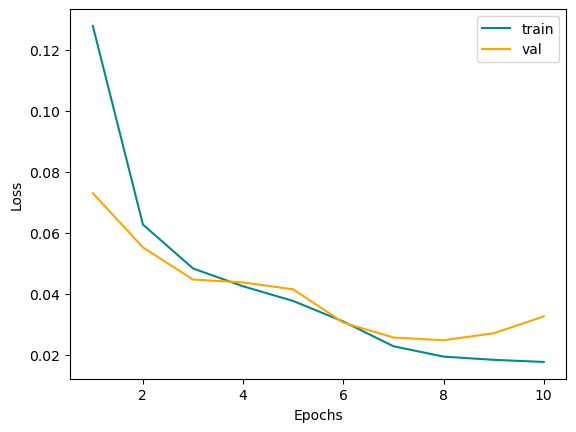

In [26]:
losses = train_VAE(gru_encoder,
                   gru_decoder,
                   style_classif,
                   adv_style_classif,
                   content_classif,
                   adv_content_classif,
                   train_loader,
                   val_loader,
                   num_epochs = 10,
                   vocab_size= vocab_size,
                   lr = 4e-4)

In [29]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = gru_encoder(prova)

    z = torch.cat((z_s,z_c),dim = 2) 

    out = gru_decoder(z)

out = out*vocab_size
out = out.view(sequence_length)

parole = []

for i in range(out.shape[0]):
    parole.append(idx2word[int(out[i].item())])

print("label: ", labels.item())
print("Input sequence: ", ' '.join(frase))
print("Reconstructed sequence: ", ' '.join(parole))

label:  0
Input sequence:  l alta provedenza che con scipio difese a roma la gloria del mondo soccorrà tosto sì com io concipio e
Reconstructed sequence:  credere paradiso cadere pei bestie favella bianchi poveretta diletto dicer badìa corto sentii pochi destro sciara attento inferno rosso costoro


In [33]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = gru_encoder(prova)

    z = torch.cat((z_s,z_c),dim = 2) 

    out = gru_decoder(z)

out = out*vocab_size
out = out.view(sequence_length)

parole = []

for i in range(out.shape[0]):
    parole.append(idx2word[int(out[i].item())])

print("label: ", labels.item())
print("Input sequence: ", ' '.join(frase))
print("Reconstructed sequence: ", ' '.join(parole))

label:  1
Input sequence:  soffiò loro lo speziale facendo gli occhiacci volete che andiamo tutti in galera sappiate che colla giustizia bisogna dir sempre
Reconstructed sequence:  disgrazia finalmente mentr vicario suol odo lavoro mentr alba avean manca seta buoni riguardar apposta comune fosso disgrazia potenza albero


In [30]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = gru_encoder(prova)

    z = torch.cat((z_s,z_c),dim = 2) 

    out = gru_decoder(z)

out = out*vocab_size
out = out.view(sequence_length)

parole = []

for i in range(out.shape[0]):
    parole.append(idx2word[int(out[i].item())])

print("label: ", labels.item())
print("Input sequence: ", ' '.join(frase))
print("Reconstructed sequence: ", ' '.join(parole))

label:  0
Input sequence:  vero e vede ch el s accorda con esso come nota con suo metro così la mia memoria si ricorda
Reconstructed sequence:  camera uscì seco creatura caccia penne partito dormire anco dolor sentite disgrazia sarai faccio discorso ospedale schiera tant piano porti


In [34]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    z_s, z_c, mu_s , log_var_s, mu_c, log_var_c = gru_encoder(prova)

    z = torch.cat((z_s,z_c),dim = 2) 

    out = gru_decoder(z)

out = out*vocab_size
out = out.view(sequence_length)

parole = []

for i in range(out.shape[0]):
    parole.append(idx2word[int(out[i].item())])

print("label: ", labels.item())
print("Input sequence: ", ' '.join(frase))
print("Reconstructed sequence: ", ' '.join(parole))

label:  1
Input sequence:  ho trovato più niente di quel che avevo lasciato e comare mena non mi è parsa più quella uno che
Reconstructed sequence:  fosser folle diversi signora aspetta pugni convenne suocero spirti francesco segue giudice cavallo contento tarì seco dolore belle folla dianzi
